Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('../bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C5_from_env_2']

['C0_from_env_0', 'C1_from_env_1', 'C5_from_env_2']


In [ ]:
# percentile is chosen manually to get 315 cells.
gs_masks = grid_score_masks(experiment, percentile=0.547, mode="intersection")
gs_idxs = np.where(gs_masks)[0]

In [ ]:
ratemaps = get_smooth_ratemaps(experiment, sigma=1.0)
gc_ratemaps = ratemaps[:,module_indices]

# choose phases from environment 0.
# assume that phases 
phase_magnitudes = np.linalg.norm(np.array(list(map(phase_fn, gc_ratemaps[0]))),axis=-1)
sort_idxs = np.argsort(phase_magnitudes)

In [5]:
def load_model(experiment):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [6]:
"""
agent = experiment.agents[0]
pcs = experiment.pc_ensembles[0]

num_trajectories = 100
len_trajectory = 1000

positions = []
velocities = []
for n in tqdm.trange(num_trajectories):
    agent.reset()
    [agent.step() for i in range(len_trajectory)]
    positions.append(agent.positions)
    velocities.append(agent.velocities[1:])

positions = np.array(positions)
velocities = np.array(velocities)
positions = torch.tensor(positions)
velocities = torch.tensor(velocities)
"""
_ = 2

In [7]:
#dataset = Dataset(experiment.agents, experiment.pc_ensembles, num_samples=1e+6, seq_len=100)
#(v,p0),labels,p,idx = dataset[0]

In [8]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [10]:
pred_errors_pruned = []
i = 0
for inputs, labels, positions, indices in dataloader:
    i+=1
    percentage_idx = int(round(len(module_indices) * (i / nsteps)))
    model.prune_mask = module_indices[:percentage_idx]
    
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions, positions, indices, model.place_cell_ensembles)
    pred_errors_pruned.append(pred_error.item())
    if i == nsteps:
        break

In [11]:
model.prune_mask = []
# check how many connections have been pruned
# --> sanity check for prune mask <--
torch.sum(model.prune_mask[1]), np.prod(model.prune_mask[1].shape)

(tensor(16777216.), 16777216)

In [12]:
pred_errors_random_prune = []
i = 0
for inputs, labels, positions, indices in dataloader:
    i+=1
    percentage_idx = int(round(len(module_indices) * (i / nsteps)))
    random_pruning = np.random.randint(model.Ng,size=percentage_idx)
    model.prune_mask = random_pruning
    
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions, positions, indices, model.place_cell_ensembles)
    pred_errors_random_prune.append(pred_error.item())
    if i == nsteps:
        break

In [13]:
# percentile is chosen manually to get 315 cells.
gs_masks = grid_score_masks(experiment, percentile=0.547, mode="intersection")
gs_idxs = np.where(gs_masks)[0]

pred_errors_gcs_prune = []
i = 0
for inputs, labels, positions, indices in dataloader:
    i+=1
    percentage_idx = int(round(len(module_indices) * (i / nsteps)))
    model.prune_mask = gs_idxs[:percentage_idx]
    
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions, positions, indices, model.place_cell_ensembles)
    pred_errors_gcs_prune.append(pred_error.item())
    if i == nsteps:
        break

In [14]:
pred_errors_pruned = []
i = 0
for inputs, labels, positions, indices in dataloader:
    i+=1
    percentage_idx = int(round(len(module_indices) * (i / nsteps)))
    model.prune_mask = module_indices[:percentage_idx]
    
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions, positions, indices, model.place_cell_ensembles)
    pred_errors_pruned.append(pred_error.item())
    if i == nsteps:
        break

In [15]:
ratemaps = get_smooth_ratemaps(experiment, sigma=1.0)
gc_ratemaps = ratemaps[:,module_indices]

# choose phases from environment 0.
# assume that phases 
phase_magnitudes = np.linalg.norm(np.array(list(map(phase_fn, gc_ratemaps[0]))),axis=-1)
sort_idxs = np.argsort(phase_magnitudes)

In [16]:
pred_errors_phase_sorted_torus_cell_pruning = []
i = 0
for inputs, labels, positions, indices in dataloader:
    i+=1
    percentage_idx = int(round(len(module_indices) * (i / nsteps)))
    model.prune_mask = module_indices[sort_idxs][:percentage_idx]
    
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions, positions, indices, model.place_cell_ensembles)
    pred_errors_phase_sorted_torus_cell_pruning.append(pred_error.item())
    if i == nsteps:
        break

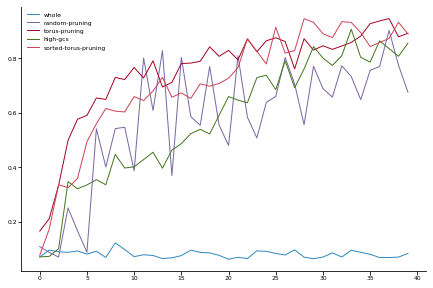

In [17]:
plt.plot(pred_errors, label='whole')
plt.plot(pred_errors_random_prune, label='random-pruning')
plt.plot(pred_errors_pruned, label='torus-pruning')
plt.plot(pred_errors_gcs_prune, label='high-gcs')
plt.plot(pred_errors_phase_sorted_torus_cell_pruning, label='sorted-torus-pruning')
plt.legend()
#plt.savefig("/home/vemundss/Desktop/prune")

In [18]:
# NEXT
# -- DONE -- prune with high GCS
# prune toroid cells sorted on phase - physics phase transtition?
# legg til error shadings på grafene.
# include adverserial attack?
# prune inverse of toroid cells. path integration remain? ratemaps still grids? toroid still there?